「画像分類タスクに対する転移学習の方法」
======
【原題】TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL

【原著】[asank Chilamkurthy](https://chsasank.github.io)

【元URL】https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年11月16日

【チュトーリアル概要】

CNNを使用した画像分類モデルに対して、転移学習を実施する方法を解説します。

---


本チュートリアルでは、画像分類用の畳み込みニューラルネットワーク（以下、ConvNetと記載）に対して、転移学習を使用して訓練する方法を学びます。

転移学習自体の詳細については、[`cs231nコースのメモ`](https://cs231n.github.io/transfer-learning/)をご参照ください。

（日本語訳注：スタンフォード大学が公開している画像認識をテーマとしたコースの資料）


以下に、上記メモの内容を引用します。

```
    実際には、(ランダムな初期値を使用して)畳み込みネットワーク全体をゼロから訓練するケースは非常に稀です。
    なぜなら、ネットワークをゼロから訓練するために十分なサイズのデータセットを用意できるケースがほとんど無いからです。
    ゼロからネットワークを訓練する代わりに、一般的には次のような対応をします。
    まず、非常に大規模なデータセット（例えばImageNetなどは120万枚の画像を1000のカテゴリに分けて収録しています）でConvNetを事前学習します。
    そしてこの訓練済みのConvNetを初期値、もしくは特徴量抽出器として実際のタスクで活用します。
```

上記の引用で紹介されていた転移学習の活用方法は、以下の2通りとなります。

- **ConvNetをファインチューニングする** :  <br>
    ランダムな値の代わりに訓練済みのパラメータを、訓練するネットワークの初期値として利用します。<br>
    例えば、imagenet1000 dataset で訓練したネットワークをこの用途に使うことができます。<br>
    訓練済みのパラメータを初期値として使う点以外は、通常通りにネットワークを訓練します。

- **ConvNetを特徴量抽出器として使う** : <br> 最後の全結合層を除いて訓練済みネットワークの重みを固定します。<br>
    次に最後の全結合層のみをランダムな重みを持つ新たなものに置き換えます。<br>
    そして、この最終層だけを訓練します。

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # インタラクティブ・モード

データの読み込み
----------------

データの読み込みには`torchvision`と`torch.utils.data`パッケージを使用します。

<br>

本チュートリアルでは、課題例として**アリ**と**ハチ**の画像を分類するモデルを訓練します。

アリとハチ、それぞれについて約120枚の訓練用画像があり、各クラスの評価用画像は75枚あります。

通常、このデータセットの画像枚数はゼロからConvNetを訓練してモデルの性能を汎化させるには不十分です。

しかし今回は転移学習（ファインチューニング）を使用するため、この量のデータセットでも効率的にモデルを汎化させることができると考えられます。

なお、このデータセットはImageNetデータセットのごく一部（サブセット）です。



**注意**：

データは[`こちら`](https://download.pytorch.org/tutorial/hymenoptera_data.zip)からダウンロードして、カレントディレクトリに解凍してください。

<br>

（日本語訳注：日本語版チュートリアルでは、データセットをダウンロードするコードを以下に実装しています）
_____

In [2]:
%%shell
# データをダウンロード
wget -P ./data https://download.pytorch.org/tutorial/hymenoptera_data.zip
# zipファイルを解凍
unzip ./data/hymenoptera_data.zip -d ./data

--2025-05-11 22:02:02--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.106, 99.86.38.37, 99.86.38.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘./data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  79.1MB/s    in 0.6s    

2025-05-11 22:02:03 (79.1 MB/s) - ‘./data/hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  ./data/hymenoptera_data.zip
   creating: ./data/hymenoptera_data/
   creating: ./data/hymenoptera_data/train/
   creating: ./data/hymenoptera_data/train/ants/
  inflating: ./data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: ./data/hymenoptera_data/tra

In [3]:
# 訓練データ用のデータ拡張と正規化
# 検証データ用には正規化のみ実施
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 画像の可視化

データ拡張（もしくはデータオーギュメンテーションと呼ぶ：Data Augmentation）を理解するために、いくつかの訓練画像を可視化してみましょう。

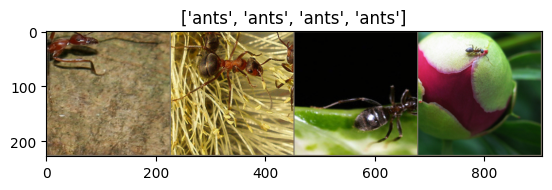

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # プロット図が更新されるように少しだけ一時停止


# 訓練データのバッチを取得する
inputs, classes = next(iter(dataloaders['train']))

# バッチからグリッドを作成する
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

モデルの訓練
--------------------

それではモデルの訓練用に、一般的な関数実装しましょう。

以下のサンプルコードでは、次の内容を実装しています。

-   学習率のスケジューリング
-   ベストモデルの保存

サンプルコードの`scheduler`という変数は、学習率をスケジュールするオブジェクト（学習率を特定のタイミングで変更する）です。

`torch.optim.lr_scheduler`クラスからインスタンス化して作られています。

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 各エポックには訓練フェーズと検証フェーズがあります
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに設定します
            else:
                model.eval()   # モードを評価するモデルを設定します

            running_loss = 0.0
            running_corrects = 0

            # データをイレテートします
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # パラメータの勾配をゼロにします
                optimizer.zero_grad()

                # 順伝播
                # 訓練の時だけ、履歴を保持します
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練の時だけ逆伝播＋オプティマイズを行います
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 損失を計算します
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # モデルをディープ・コピーします
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # ベストモデルの重みをロードします
    model.load_state_dict(best_model_wts)
    return model

### モデル予測値の可視化

適当な数枚の画像に対する予測結果を表示する、汎用的な関数を実装します。

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNetをファインチューニングする方法
--------------------

訓練済みモデルをロードし、最後の全結合層を新しいものに置き換えます。

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# ここでは，各出力サンプルのサイズは2に設定されています
# なお、NN.Linear(num_ftrs, len(class_names))という書き方で一般化することもできます。
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# ネットワークのすべてのパラメータが最適化対象です
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7エポックごとに学習率を1/10ずつ減衰させます
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.5MB/s]


### 訓練と評価

訓練と評価にかかる時間はCPU環境では15～25分くらいで、GPU環境では1分未満です。

（日本語訳注：本ノートブックはGoogle ColaboratoryのGPU設定で保存しています）

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6099 Acc: 0.6844
val Loss: 0.5857 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.5388 Acc: 0.7705
val Loss: 0.4512 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.6011 Acc: 0.7746
val Loss: 0.5330 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.5871 Acc: 0.7746
val Loss: 0.5868 Acc: 0.8301

Epoch 4/24
----------
train Loss: 0.3609 Acc: 0.8484
val Loss: 0.4511 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4498 Acc: 0.8443
val Loss: 0.3087 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4265 Acc: 0.8320
val Loss: 0.2734 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3516 Acc: 0.8279
val Loss: 0.2834 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3625 Acc: 0.8279
val Loss: 0.2727 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3288 Acc: 0.8443
val Loss: 0.2450 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3463 Acc: 0.8689
val Loss: 0.2432 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2343 Acc: 0.8934
val Loss: 0.2388 Acc: 0.9020

Ep

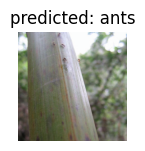

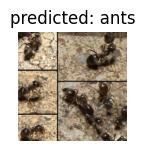

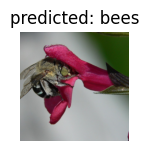

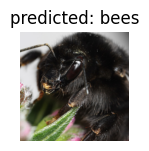

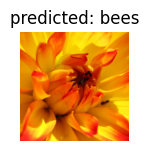

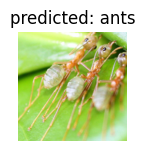

In [9]:
visualize_model(model_ft)

## Conv Netを特徴抽出器として使う方法

今回のケースでは、最後の全結合層を除くすべてのネットワークのパラメータを固定します。

パラメータを固定するためには、`requires_grad = False `を設定する必要があります。

これによって、`backward()`で勾配が計算されないようになります。

<br>

勾配計算の詳細は[こちら](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)のドキュメントをご覧ください

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 新しく構築されたモジュールのパラメータは、デフォルトでは requires_grad=True になっています。
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

 # ファインチューニングとは違い、最終層のパラメータのみが最適化されていることを確認してください
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7エポックごとに学習率を0.1倍ずつ減衰させる
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 訓練と評価

ファインチューニングの場合に比べると、訓練と評価にかかる時間はCPUを使う場合でも約半分になります。

ほとんどのネットワークで勾配を計算する必要がないために、このような訓練時間の短縮を見込むことができます。

ただし、順伝播の計算が不要になるわけではありません。

<br>

（日本語訳注：上記説明では、勾配をrequires_grad = Falseにすると記載・説明されていますが、明示的にその操作をせず、代わりに、SGDでの訓練対象をmodel_conv.fc.parameters()として、最終層のみが訓練対象になるように設定されています。）


In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5381 Acc: 0.7008
val Loss: 0.3980 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.5084 Acc: 0.7377
val Loss: 0.2069 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.3944 Acc: 0.8156
val Loss: 0.1756 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4104 Acc: 0.8033
val Loss: 0.2046 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.6211 Acc: 0.7582
val Loss: 0.1642 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4728 Acc: 0.7951
val Loss: 0.1963 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.5274 Acc: 0.7787
val Loss: 0.4083 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.3384 Acc: 0.8648
val Loss: 0.2039 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4329 Acc: 0.8115
val Loss: 0.1867 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3514 Acc: 0.8484
val Loss: 0.1980 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3739 Acc: 0.8484
val Loss: 0.1831 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2891 Acc: 0.8811
val Loss: 0.1912 Acc: 0.9412

Ep

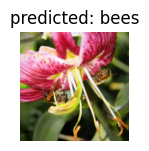

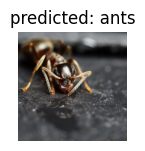

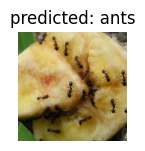

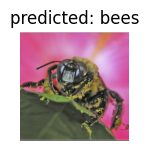

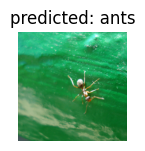

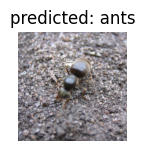

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

さらなる学習のために
------------

転移学習の応用についてさらに学びたい方は、[画像認識のための量子を用いた転移学習チュートリアル（Quantized Transfer Learning for Computer Vision Tutorial）](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html)もチェックしてみてください。